In [92]:
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import linregress
import numpy as np
from sklearn import datasets
import pandas as pd
from config import api_key
import requests
import json
from datetime import datetime

In [93]:
tickers = ["AAPL", "GOOG", "AMZN"]

dummy = pd.DataFrame(columns = ["ticker", "o", "c", "t"])

#create loop to run through URL & save info into lists
for name in tickers:
    base_url = f"https://api.polygon.io/v2/aggs/ticker/{name}/range/1/day/2012-01-01/2022-10-24?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"
    response = requests.get(base_url).json()
    datadata = pd.json_normalize(response["results"])
    datadata["ticker"] = name
    datadata = datadata[["ticker", "o", "c", "t"]]

#print(datadata)
    dummy = pd.concat([dummy,datadata])
dummy.columns=["ticker", "open", "close", "date"]

#pd.concat([dummy,datadata],axis=0)
print(dummy.head())


  ticker     open    close           date
0   AAPL  21.2457  21.2614  1351656000000
1   AAPL  21.3650  21.3050  1351742400000
2   AAPL  21.2818  20.6000  1351828800000
3   AAPL  20.8398  20.8793  1352091600000
4   AAPL  21.0796  20.8161  1352178000000


In [94]:
#Print types
dummy.info()
#Convert unix to datetime & remove hours/miuntes
dummy['date'] = pd.to_datetime(dummy['date'],unit='ms')
dummy["date"] = pd.to_datetime(dummy["date"]).dt.date
#dummy.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7539 entries, 0 to 2512
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ticker  7539 non-null   object 
 1   open    7539 non-null   float64
 2   close   7539 non-null   float64
 3   date    7539 non-null   object 
dtypes: float64(2), object(2)
memory usage: 294.5+ KB


In [107]:
#Create copy of dummy
tickers_copy = dummy.copy(deep=True)
#delete
del tickers_copy["open"]
#tickers_copy
#Create copy of dummy for %change & $change
tickers_pctchange = tickers_copy.copy(deep=True)


#Divide dataframes into new dataframes by ticker
aapl_daily2 = tickers_pctchange[tickers_pctchange["ticker"] == "AAPL"]
aapl_daily2 = pd.DataFrame(aapl_daily2)
#print(aapl_daily2.head())
amzn_daily2 = tickers_pctchange[tickers_pctchange["ticker"] == "AMZN"]
amzn_daily2 = pd.DataFrame(amzn_daily2)
#print(amzn_daily2.head())
goog_daily2 = tickers_pctchange[tickers_pctchange["ticker"] == "GOOG"]
goog_daily2 = pd.DataFrame(goog_daily2)
#print(goog_daily2.head())

#rename close as ticker to prepare to merge by date
aapl_daily2.rename(columns = {'close':'AAPL'}, inplace = True)
del aapl_daily2["ticker"]
amzn_daily2.rename(columns = {'close':'AMZN'}, inplace = True)
del amzn_daily2["ticker"]
goog_daily2.rename(columns = {'close':'GOOG'}, inplace = True)
del goog_daily2["ticker"]

#make copy for prices 
aapl_prices = aapl_daily2.copy(deep=True)
amzn_prices = amzn_daily2.copy(deep=True)
goog_prices = goog_daily2.copy(deep=True)
print(aapl_prices)

#make copy for $ changes
aapl_bch = aapl_daily2.copy(deep=True)
amzn_bch = amzn_daily2.copy(deep=True)
goog_bch = goog_daily2.copy(deep=True)
#print(goog_bch)

#calculate % change
aapl_daily2["AAPL"]=aapl_daily2["AAPL"].pct_change()*100
amzn_daily2["AMZN"]=amzn_daily2["AMZN"].pct_change()*100
goog_daily2["GOOG"]=goog_daily2["GOOG"].pct_change()*100
aapl_daily2 = aapl_daily2[["date", "AAPL"]]
#aapl_daily2

          AAPL        date
0      21.2614  2012-10-31
1      21.3050  2012-11-01
2      20.6000  2012-11-02
3      20.8793  2012-11-05
4      20.8161  2012-11-06
...        ...         ...
2508  143.7500  2022-10-18
2509  143.8600  2022-10-19
2510  143.3900  2022-10-20
2511  147.2700  2022-10-21
2512  149.4500  2022-10-24

[2513 rows x 2 columns]


In [102]:
#merge tables % change
merge_pctchange = aapl_daily2.merge(amzn_daily2, on='date', how='left')
merge_pctchange = merge_pctchange.merge(goog_daily2, on="date", how="left")
#merge_pctchange.head()

#merge tables prices 
merge_prices = aapl_prices.merge(amzn_prices, on='date', how='left')
merge_prices = merge_prices.merge(goog_prices, on="date", how="left")

#merge tables $change
merge_bch = aapl_bch.merge(amzn_bch, on='date', how='left')
merge_bch = merge_bch.merge(goog_bch, on="date", how="left")
merge_bch.head()

#reorder columns
merge_pctchange= merge_pctchange[['date','AAPL','GOOG', "AMZN"]]
merge_prices= merge_prices[['date','AAPL','GOOG', "AMZN"]]
merge_bch= merge_bch[['date','AAPL','GOOG', "AMZN"]]



<Figure size 432x288 with 0 Axes>

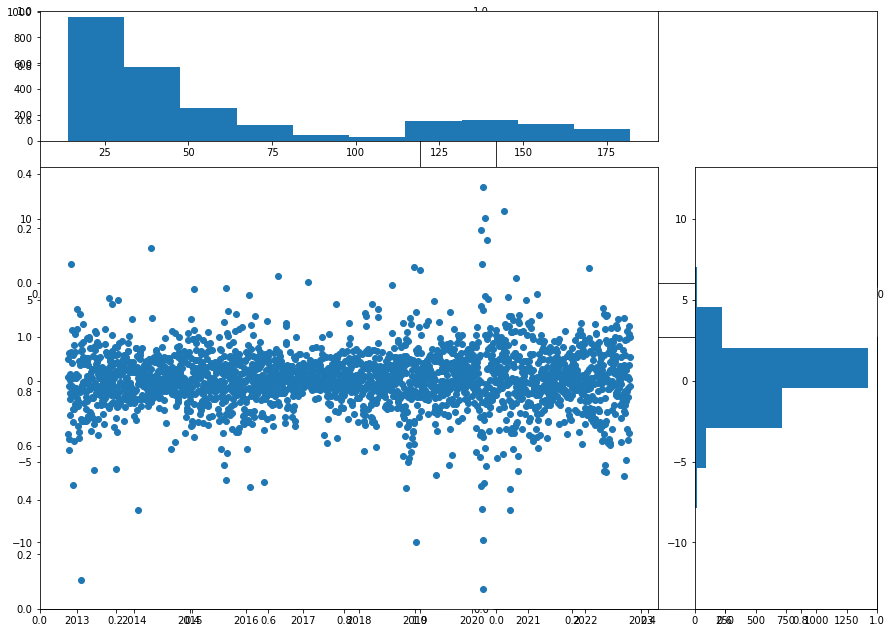

In [115]:
#Creating & plotting scatter/histogram for % &$ distribution
fig= plt.figure()
fig, ax = plt.subplots(2, 2, figsize=(15,11))
gs=GridSpec(4,4)
ax_scatter=fig.add_subplot(gs[1:4, 0:3])
ax_hist_y=fig.add_subplot(gs[0,0:3])
ax_hist_x=fig.add_subplot(gs[1:4,3])
ax_scatter.scatter(aapl_daily2["date"], aapl_daily2["AAPL"])
ax_hist_x.hist(aapl_daily2["AAPL"], orientation="horizontal")
ax_hist_y.hist(aapl_prices["AAPL"])
plt.show()

<Figure size 432x288 with 0 Axes>

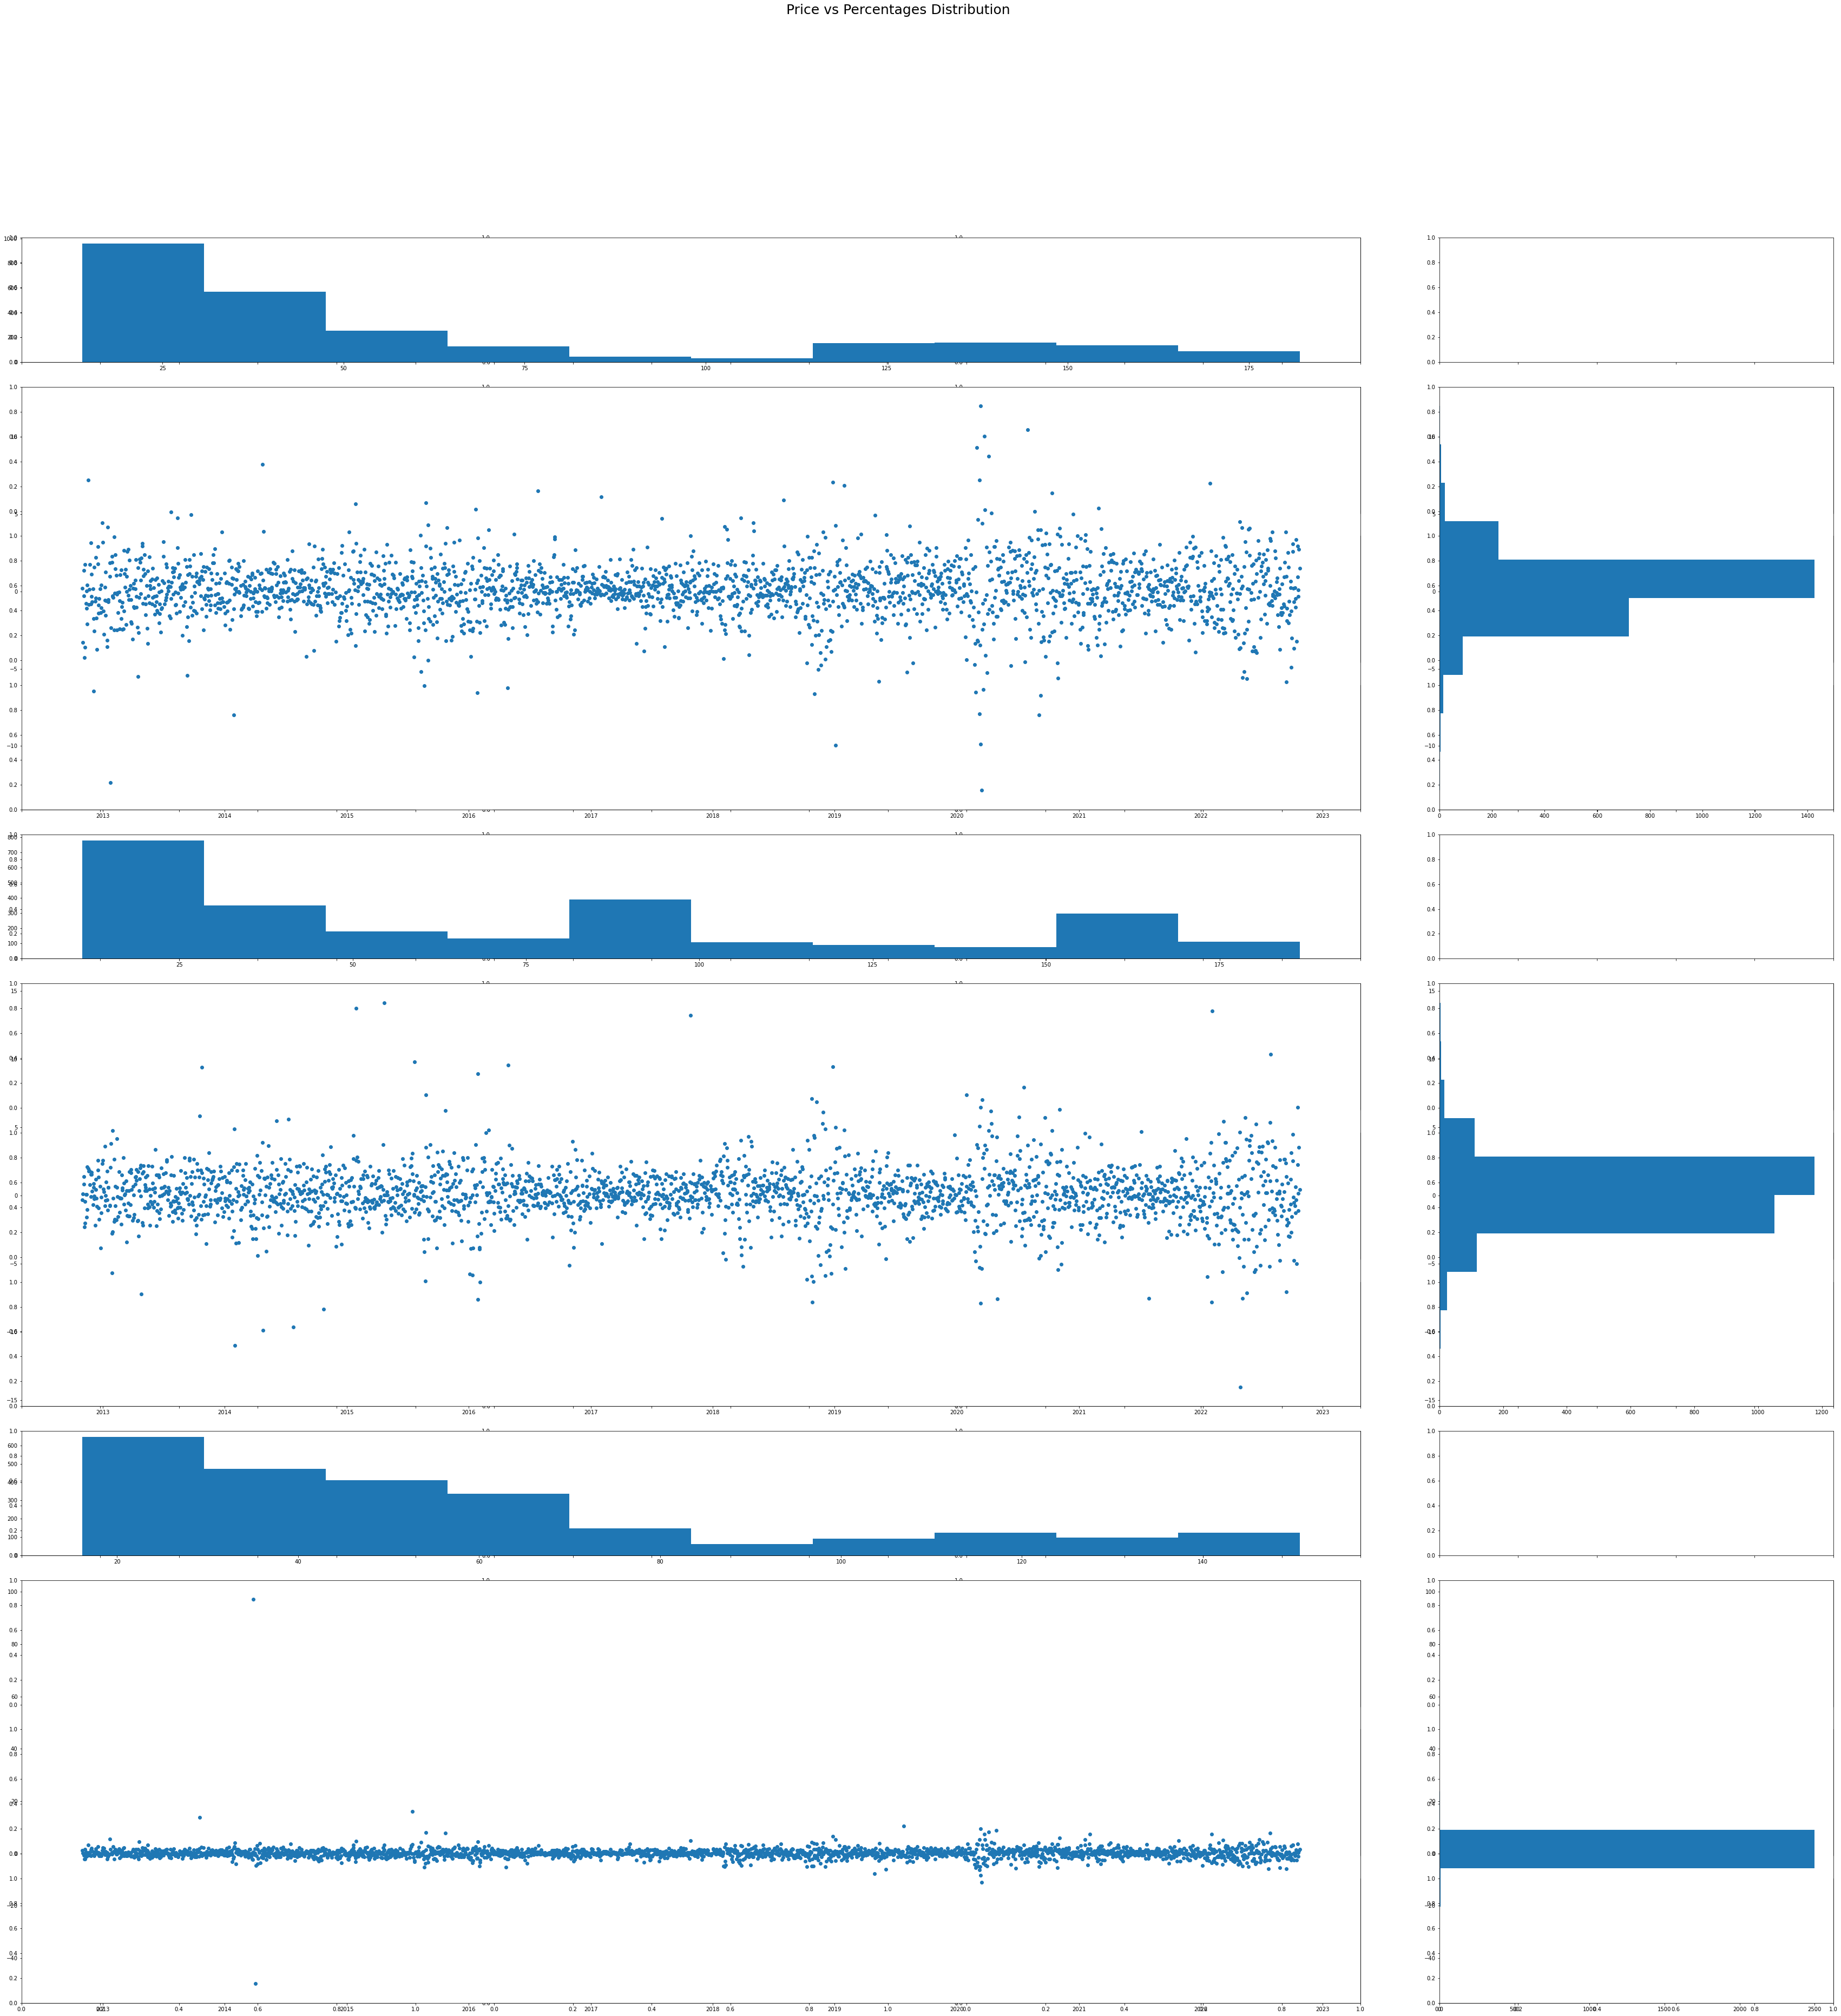

In [159]:
#Creating & plotting scatter/histogram for % &$ distribution
fig= plt.figure()
#fig, ax = plt.subplots(12, 4, figsize=(80,80))
fig, ax = plt.subplots(23,3, sharex=True, sharey=False,figsize=(60,60))
gs=GridSpec(12,4)
plt.suptitle('Price vs Percentages Distribution', fontsize=25)
#AAPL subplots
ax_hist_aapl_y=fig.add_subplot(gs[0:1,0:3])
ax_hist_aapl_y.hist(aapl_prices["AAPL"])
ax_scatter_aapl=fig.add_subplot(gs[2:7, 0:3])
ax_scatter_aapl.scatter(aapl_daily2["date"], aapl_daily2["AAPL"])
ax_hist_aapl_x=fig.add_subplot(gs[2:7,3])
ax_hist_aapl_x.hist(aapl_daily2["AAPL"], orientation="horizontal")
#add AMZN subplots
ax_hist_amzn_y=fig.add_subplot(gs[8:9,0:3])
ax_hist_amzn_y.hist(amzn_prices["AMZN"])
ax_scatter_amzn=fig.add_subplot(gs[10:15, 0:3])
ax_scatter_amzn.scatter(amzn_daily2["date"], amzn_daily2["AMZN"])
ax_hist_amzn_x=fig.add_subplot(gs[10:15,3])
ax_hist_amzn_x.hist(amzn_daily2["AMZN"], orientation="horizontal")
#add GOOGL subplots
ax_scatter_goog=fig.add_subplot(gs[16:17, 0:3])
ax_scatter_goog.scatter(goog_daily2["date"], goog_daily2["GOOG"])
ax_hist_goog_y=fig.add_subplot(gs[9,0:3])
ax_hist_goog_y.hist(goog_prices["GOOG"])
ax_hist_goog_x=fig.add_subplot(gs[18:23,3])
ax_hist_goog_x.hist(goog_daily2["GOOG"], orientation="horizontal")
plt.show()

In [81]:
#aapl_plot, = plt.plot(merge_pctchange["date"], merge_pctchange["AAPL"], color="blue", label="AAPL" )
#amzn, = plt.plot(merge_pctchange["date"], merge_pctchange["AMZN"], color="red", label="AMZN" )
#goog, = plt.plot(merge_pctchange["date"], merge_pctchange["GOOG"], color="green", label="GOOG" )
#plt.show()

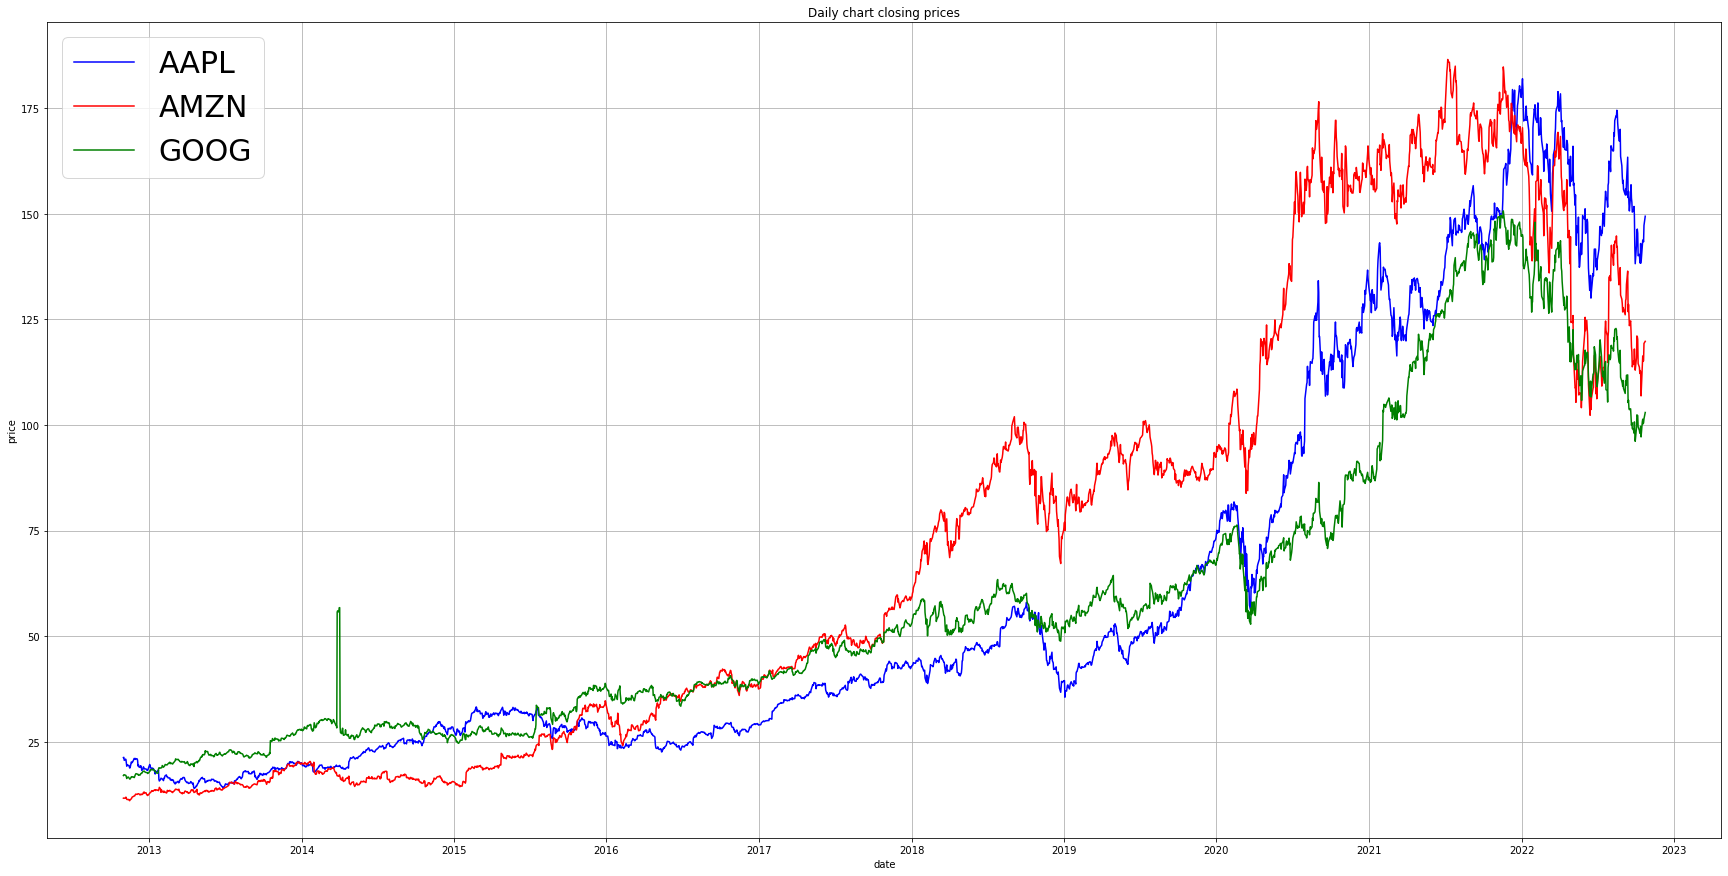

In [12]:
plt.figure(figsize=(30,15))
aapl_daily_chart, = plt.plot(merge_bch["date"], merge_bch["AAPL"], color='blue', label="AAPL")
amzn_daily_chart, = plt.plot(merge_bch["date"], merge_bch["AMZN"], color='red', label="AMZN")
goog_daily_chart, = plt.plot(merge_bch["date"], merge_bch["GOOG"], color='green', label="GOOG")
plt.grid()
plt.xlabel("date")
plt.ylabel("price")
plt.title("Daily chart closing prices")
plt.legend(fontsize = "30",loc="upper left")

In [13]:
pd.set_option('display.max_columns', None)

In [14]:
tickers2 = ["AAPL", "GOOG", "AMZN"]

dum_financials = pd.DataFrame(columns = ["start_date","end_date", "company_name", "fiscal_period", "fiscal_year", 
                                        "financials.income_statement.revenues.value", 
                                        "financials.income_statement.net_income_loss.value", 
                                        "financials.income_statement.gross_profit.value", 
                                        "financials.income_statement.basic_earnings_per_share.value"])

#create loop to run through URL & save info into lists
for name in tickers2:
    base_financials = f"https://api.polygon.io/vX/reference/financials?ticker={name}&timeframe=quarterly&limit=40&sort=period_of_report_date&apiKey={api_key}"
    financials_response = requests.get(base_financials).json()
    datafinancials = pd.json_normalize(financials_response["results"])
#    datafinancials = pd.json_normalize(financials_response, max_level=5, record_path=["results"])
    datafinancials["company_name"] = name

    datafinancials = datafinancials[["start_date","end_date", "company_name", "fiscal_period", "fiscal_year", 
                                        "financials.income_statement.revenues.value", 
                                        "financials.income_statement.net_income_loss.value", 
                                        "financials.income_statement.gross_profit.value", 
                                        "financials.income_statement.basic_earnings_per_share.value"]]
    dum_financials= pd.concat([dum_financials,datafinancials])
dum_financials.columns=["Start Date", "End Date", "Company Name", "Fiscal Period", "Fiscal Year", "Revnue", 
                      "Net Income/Loss", "Gross Profit", "EPS"]
print(dum_financials)


    Start Date    End Date Company Name Fiscal Period Fiscal Year  \
0   2022-03-27  2022-06-25         AAPL            Q3        2022   
1   2021-12-26  2022-03-26         AAPL            Q2        2022   
2   2021-09-26  2021-12-25         AAPL            Q1        2022   
3   2021-03-28  2021-06-26         AAPL            Q3        2021   
4   2020-12-27  2021-03-27         AAPL            Q2        2021   
..         ...         ...          ...           ...         ...   
34  2011-01-01  2011-03-31         AMZN            Q1        2011   
35  2010-04-01  2010-06-30         AMZN            Q2        2010   
36  2010-01-01  2010-03-31         AMZN            Q1        2010   
37  2009-07-01  2009-09-30         AMZN                             
38  2009-04-01  2009-06-30         AMZN                             

          Revnue  Net Income/Loss  Gross Profit   EPS  
0   8.295900e+10     1.944200e+10  3.588500e+10  1.20  
1   9.727800e+10     2.501000e+10  4.255900e+10  1.54  
2  

In [29]:
tickers3 = ["AAPL", "GOOG", "AMZN"]

dum_fiscal_year_is = pd.DataFrame(columns = ["date", "symbol", "fillingDate", "calendarYear", 
                                          "period", "revenue", "grossProfit", "netIncome", 
                                          "eps", "weightedAverageShsOut"])

prep_key = "b4fe65382da39adf450a1bdfc846fd2e"
for name in tickers3:
    query_url = f"https://financialmodelingprep.com/api/v3/income-statement/{name}?limit=120&apikey={prep_key}"
    fiscal_response = requests.get(query_url).json()
    fiscal_year_is = pd.json_normalize(fiscal_response)
    fiscal_year_is["symbol"] = name
    fiscal_year_is = fiscal_year_is[["date", "symbol", "fillingDate", "calendarYear", 
                                "period", "revenue", "grossProfit", "netIncome", 
                                "eps", "weightedAverageShsOut"]]
    dum_fiscal_year_is= pd.concat([dum_fiscal_year_is,fiscal_year_is])
dum_fiscal_year_is.columns=["Date", "Ticker", "Filing Date", "Fiscal Year", "Period", 
                      "Revenue", "Gross Profit", "Net Income", "EPS", "Shares Outstanding"]
#print(dum_fiscal_year_is)
#Create copy that won't affect original
fiscal_years_is = dum_fiscal_year_is.copy(deep=True)

#fiscal_years
#Create separate dataframe based on symbols
aapl_yis = fiscal_years_is[fiscal_years_is["Ticker"] == "AAPL"]
aapl_yis = pd.DataFrame(aapl_yis)
#print(aapl_fiscal_year.head())
amzn_yis = fiscal_years_is[fiscal_years_is["Ticker"] == "AMZN"]
amzn_yis = pd.DataFrame(amzn_yis)
#print(amzn_fiscal_year.head())
goog_yis = fiscal_years_is[fiscal_years_is["Ticker"] == "GOOG"]
goog_yis = pd.DataFrame(goog_yis)
goog_yis.tail()

,Date,Ticker,Filing Date,Fiscal Year,Period,Revenue,Gross Profit,Net Income,EPS,Shares Outstanding
17,2004-12-31,GOOG,2004-12-31,2004,FY,3189223000,1731570000,3.99119e+08,0.1035,3863518454
18,2003-12-31,GOOG,2003-12-31,2003,FY,1465934000,840080000,1.05648e+08,0.0385,2753938898
19,2002-12-31,GOOG,2002-12-31,2002,FY,439508000,307998000,9.9656e+07,0.0385,2753938898
20,2001-12-31,GOOG,2001-12-31,2001,FY,86426000,72198000,6.985e+06,0.0035,1890459243
21,2000-12-31,GOOG,2000-12-31,2000,FY,19108000,13027000,-1.469e+07,-0.0110,1340639463


In [28]:
tickers3 = ["AAPL", "GOOG", "AMZN"]

dum_fiscal_qis = pd.DataFrame(columns = ["date", "symbol", "fillingDate", "calendarYear", 
                                          "period", "revenue", "grossProfit", "netIncome", 
                                          "eps", "weightedAverageShsOut"])

prep_key = "b4fe65382da39adf450a1bdfc846fd2e"
for name in tickers3:
    query_url = f"https://financialmodelingprep.com/api/v3/income-statement/{name}?period=quarter&limit=400&apikey={prep_key}"
    fiscal_response = requests.get(query_url).json()
    fiscal_yearqis = pd.json_normalize(fiscal_response)
    fiscal_yearqis["symbol"] = name
    fiscal_yearqis = fiscal_yearqis[["date", "symbol", "fillingDate", "calendarYear", 
                                "period", "revenue", "grossProfit", "netIncome", 
                                "eps", "weightedAverageShsOut"]]
    dum_fiscal_yearqis= pd.concat([dum_fiscal_qis,fiscal_yearqis])
dum_fiscal_yearqis.columns=["Date", "Ticker", "Filing Date", "Fiscal Year", "Period", 
                      "Revenue", "Gross Profit", "Net Income", "EPS", "Shares Outstanding"]
#print(dum_fiscal_yearqis)
#Create copy that won't affect original
fiscal_yearsqis = dum_fiscal_yearqis.copy(deep=True)

#fiscal_years
#Create separate dataframe based on symbols
aapl_qis = fiscal_yearsqis[fiscal_yearsqis["Ticker"] == "AAPL"]
aapl_qis = pd.DataFrame(aapl_qis)
#print(aapl_fiscal_year.head())
amzn_qis = fiscal_yearsqis[fiscal_yearsqis["Ticker"] == "AMZN"]
amzn_qis = pd.DataFrame(amzn_qis)
#print(amzn_fiscal_year.head())
goog_qis = fiscal_years_is[fiscal_years_is["Ticker"] == "GOOG"]
goog_qis = pd.DataFrame(goog_qis)
goog_qis.tail()

,Date,Ticker,Filing Date,Fiscal Year,Period,Revenue,Gross Profit,Net Income,EPS,Shares Outstanding
17,2004-12-31,GOOG,2004-12-31,2004,FY,3189223000,1731570000,3.99119e+08,0.1035,3863518454
18,2003-12-31,GOOG,2003-12-31,2003,FY,1465934000,840080000,1.05648e+08,0.0385,2753938898
19,2002-12-31,GOOG,2002-12-31,2002,FY,439508000,307998000,9.9656e+07,0.0385,2753938898
20,2001-12-31,GOOG,2001-12-31,2001,FY,86426000,72198000,6.985e+06,0.0035,1890459243
21,2000-12-31,GOOG,2000-12-31,2000,FY,19108000,13027000,-1.469e+07,-0.0110,1340639463


In [20]:
tickers3 = ["AAPL", "GOOG", "AMZN"]

dum_fiscal_ybs = pd.DataFrame(columns = ["date", "symbol", "fillingDate", "calendarYear", 
                                          "period", "cashAndCashEquivalents", "shortTermDebt", "longTermDebt"])

prep_key = "b4fe65382da39adf450a1bdfc846fd2e"
for name in tickers3:
    query_url = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{name}?limit=120&apikey={prep_key}"

    fiscal_response = requests.get(query_url).json()
    fiscal_ybs = pd.json_normalize(fiscal_response)
    fiscal_ybs["symbol"] = name
    fiscal_ybs = fiscal_ybs[["date", "symbol", "fillingDate", "calendarYear", 
                                    "period", "cashAndCashEquivalents", "shortTermDebt", "longTermDebt"]]
    dum_fiscal_ybs= pd.concat([dum_fiscal_ybs,fiscal_ybs])
dum_fiscal_ybs.columns=["Date", "Ticker", "Filing Date", "Fiscal Year", "Period", 
                      "Cash & Cash Equivalents", "Short Term Debt", "Long Term Debt"]
#print(dum_fiscal_ybs)
#Create copy that won't affect original
fiscal_ybs = dum_fiscal_ybs.copy(deep=True)

#fiscal_years
#Create separate dataframe based on symbols
aapl_ybs = fiscal_ybs[fiscal_ybs["Ticker"] == "AAPL"]
aapl_ybs = pd.DataFrame(aapl_ybs)
#print(aapl_fiscal_year.head())
amzn_ybs = fiscal_ybs[fiscal_ybs["Ticker"] == "AMZN"]
amzn_ybs = pd.DataFrame(amzn_ybs)
#print(amzn_fiscal_year.head())
goog_ybs = fiscal_ybs[fiscal_ybs["Ticker"] == "GOOG"]
goog_ybs = pd.DataFrame(goog_ybs)
goog_ybs.tail()

          Date Ticker Filing Date Fiscal Year Period Cash & Cash Equivalents  \
0   2021-09-25   AAPL  2021-10-29        2021     FY             34940000000   
1   2020-09-26   AAPL  2020-10-30        2020     FY             38016000000   
2   2019-09-28   AAPL  2019-10-31        2019     FY             48844000000   
3   2018-09-29   AAPL  2018-11-05        2018     FY             25913000000   
4   2017-09-30   AAPL  2017-11-03        2017     FY             20289000000   
..         ...    ...         ...         ...    ...                     ...   
21  2000-12-31   AMZN  2001-03-23        2000     FY             8.22435e+08   
22  1999-12-31   AMZN  2000-03-29        1999     FY             1.16962e+08   
23  1998-12-31   AMZN  1999-03-05        1998     FY              2.5561e+07   
24  1997-12-31   AMZN  1997-12-31        1997     FY               1.098e+08   
25  1996-12-31   AMZN  1996-12-31        1996     FY                 6.2e+06   

    Short Term Debt  Long Term Debt  
0

In [27]:
tickers3 = ["AAPL", "GOOG", "AMZN"]

dum_fiscal_qbs = pd.DataFrame(columns = ["date", "symbol", "fillingDate", "calendarYear", 
                                          "period", "cashAndCashEquivalents", "shortTermDebt", "longTermDebt"])

prep_key = "b4fe65382da39adf450a1bdfc846fd2e"
for name in tickers3:
    query_url = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{name}?period=quarter&limit=400&apikey={prep_key}"
    fiscal_response = requests.get(query_url).json()
    fiscal_qbs = pd.json_normalize(fiscal_response)
    fiscal_qbs["symbol"] = name
    fiscal_qbs = fiscal_qbs[["date", "symbol", "fillingDate", "calendarYear", 
                                    "period", "cashAndCashEquivalents", "shortTermDebt", "longTermDebt"]]
    dum_fiscal_qbs= pd.concat([dum_fiscal_qbs,fiscal_qbs])
dum_fiscal_qbs.columns=["Date", "Ticker", "Filing Date", "Fiscal Year", "Period", 
                      "Cash & Cash Equivalents", "Short Term Debt", "Long Term Debt"]
#print(dum_fiscal_qbs)
#Create copy that won't affect original
fiscal_qbs = dum_fiscal_qbs.copy(deep=True)
#print(fiscal_qbs)

#Create separate dataframe based on symbols
aapl_qbs = fiscal_qbs[fiscal_qbs["Ticker"] == "AAPL"]
aapl_qbs = pd.DataFrame(aapl_qbs)

amzn_qbs = fiscal_qbs[fiscal_qbs["Ticker"] == "AMZN"]
amzn_qbs = pd.DataFrame(amzn_qbs)

goog_qbs = fiscal_qbs[fiscal_qbs["Ticker"] == "GOOG"]
goog_qbs = pd.DataFrame(goog_qbs)
goog_qbs.head()

,Date,Ticker,Filing Date,Fiscal Year,Period,Cash & Cash Equivalents,Short Term Debt,Long Term Debt
0,2022-09-30,GOOG,2022-10-26,2022,Q3,21984000000,0.000000e+00,2.663700e+10
1,2022-06-30,GOOG,2022-07-27,2022,Q2,17936000000,2.297000e+09,2.643100e+10
2,2022-03-31,GOOG,2022-04-27,2022,Q1,20886000000,2.267000e+09,2.615400e+10
3,2021-12-31,GOOG,2022-02-02,2021,Q4,20945000000,2.189000e+09,2.620600e+10
4,2021-09-30,GOOG,2021-10-27,2021,Q3,23719000000,2.101000e+09,2.575900e+10


In [31]:
tickers3 = ["AAPL", "GOOG", "AMZN"]

tickers_ratios = pd.DataFrame(columns = ["date", "symbol", 
                                          "period", "priceEarningsRatio", "priceEarningsToGrowthRatio"])

prep_key = "b4fe65382da39adf450a1bdfc846fd2e"
for name in tickers3:
    query_url = f"https://financialmodelingprep.com/api/v3/ratios/{name}?period=quarter&limit=140&apikey={prep_key}"
    ratios_response = requests.get(query_url).json()
    tickers_ratio_response = pd.json_normalize(ratios_response)
    tickers_ratio_response["symbol"] = name
    tickers_ratio_response = tickers_ratio_response[["date", "symbol", 
                                          "period", "priceEarningsRatio", "priceEarningsToGrowthRatio"]]
    tickers_ratios= pd.concat([tickers_ratios,tickers_ratio_response])
tickers_ratios.columns=["Date", "Ticker", "Period", "PE", "PEG"]
#print(tickers_ratios)

#Create copy that won't affect original
ticker_ratios = tickers_ratios.copy(deep=True)
#print(fiscal_qbs)

#Create separate dataframe based on symbols
aapl_ratios = ticker_ratios[ticker_ratios["Ticker"] == "AAPL"]
aapl_ratios = pd.DataFrame(aapl_ratios)

amzn_ratios = ticker_ratios[ticker_ratios["Ticker"] == "AMZN"]
amzn_ratios = pd.DataFrame(amzn_ratios)

goog_ratios = ticker_ratios[ticker_ratios["Ticker"] == "GOOG"]
goog_ratios = pd.DataFrame(goog_ratios)
goog_ratios.head()

,Date,Ticker,Period,PE,PEG
0,2022-09-30,GOOG,Q3,22.496059,-1.829679
1,2022-06-30,GOOG,Q2,22.440763,-24.962599
2,2022-03-31,GOOG,Q1,28.045909,-1.417429
3,2021-12-31,GOOG,Q4,23.222970,2.403562
4,2021-09-30,GOOG,Q3,23.426947,8.722001
